In [1]:
import pandas as pd
import os

The data to produce the recruitment plot is contained in the file `syn_Ctg51.counts.2017-01-28.tar.gz` which can be downloaded from: https://osf.io/q3khc/

In [2]:
# Folder where syn_Ctg51.counts.2017-01-28.tar.gz was uncompressed
counts_folder = '../data/aln/'

In [3]:
# Load metadata dataframes and renames columns

# TARA metadata
metadata_file = "../data/TARA_metadata.csv"
metadata_df = pd.read_csv(metadata_file)
metadata_df = metadata_df.rename(columns = {'ENA-RUN':'dataset', "ENA-SPOT-COUNT":"dataset_size"})
metadata_df_slim = metadata_df[["dataset", "Station", "Depth", "fraction"]].copy()


In [4]:
metadata_df_slim = metadata_df_slim.loc[metadata_df_slim["fraction"].isin(["VIRUS", "BACT"])]

In [6]:
metadata_df_slim.tail()

,dataset,Station,Depth,fraction
394,ERR598961,TARA_111,90,BACT
395,ERR598960,TARA_065,850,BACT
396,ERR598963,TARA_149,5,BACT
397,ERR598962,TARA_102,40,BACT
398,ERR599028,TARA_036,17,BACT


'212117be5245e291dddd0264783d32e6' is the hashed name for the whole concatenated genome of WH8016

'f7d6bbba8cff691def235b73be363f6a' contig 51

In [15]:
# Concatenates the different tsv files with the counts into a tidy dataframe
counts_df = pd.DataFrame()
list_ = []
for path, dirs, files in os.walk(counts_folder):
    for filename in files:
        if 'f7d6bbba8cff691def235b73be363f6a' in filename:
            dataset_name = filename.split('.')[0].split('_')[0]
            if dataset_name in metadata_df_slim["dataset"].unique():
                file_path = os.path.join(path, filename)
                dataset_df = pd.read_csv(file_path, sep='\t', names=['read','id','score','pos'], index_col=None)
                dataset_df['dataset'] = dataset_name
                list_.append(dataset_df)
counts_df = pd.concat(list_)
del list_

In [17]:
# Add metadata columns
counts_df = counts_df.merge(metadata_df_slim, on='dataset', how='left')
#counts_df = counts_df.merge(genome_info_df, on='genome_hash', how='left')

---

# Recruitment plot

In [20]:
%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [21]:
from matplotlib.backends.backend_pdf import PdfPages

In [22]:
color_dict = {'BACT':'b', 'VIRUS':'r'}

In [23]:
mpl.rcParams['agg.path.chunksize'] = 10000

## Warning #1: the sorting step can slow!

In [24]:
counts_df = counts_df.sort_values(["Fraction", "pos"])

## Warning #2: the plotting is even slower!

Text(25.5584,0.5,'% Identity')

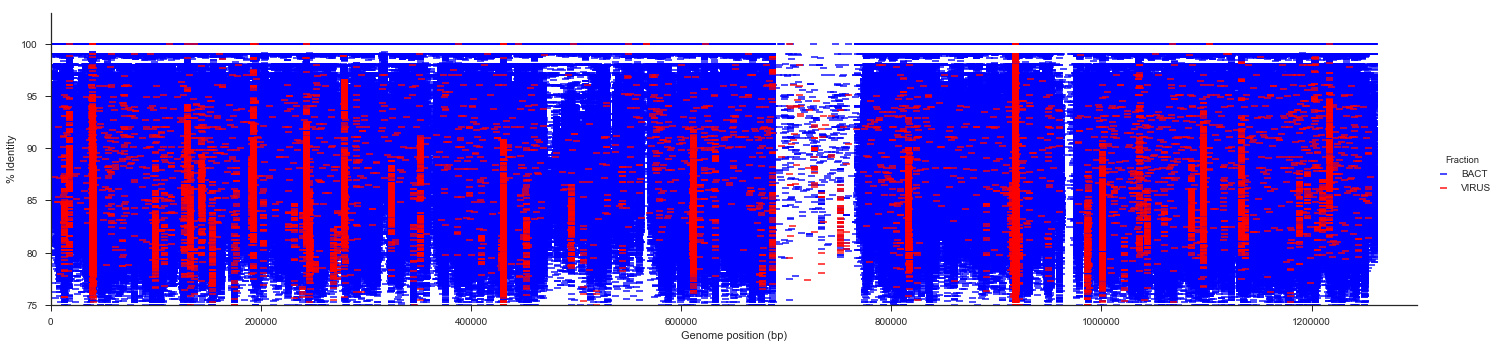

In [25]:
#pp = PdfPages('wh8016.pdf')
sns.set_context("notebook", font_scale=1)
sns.set_style("ticks")

g = sns.lmplot('pos', 'id', 
           data=counts_df, 
           fit_reg=False,
           hue="Fraction", aspect=4, markers='_', palette=color_dict)
g = (g.set(xlim=(0,1300000), ylim=(75,103)))
#plt.title('coverage')
plt.xlabel('Genome position (bp)')
plt.ylabel('% Identity')

#g.savefig('wh8016.pdf')

## To save the plot in TIFF:

In [26]:
from PIL import Image
from io import BytesIO
# save figure
# (1) save the image in memory in PNG format
png1 = BytesIO()
g.savefig(png1, format='png', dpi=300)

# (2) load this image into PIL
png2 = Image.open(png1)

# (3) save as TIFF
png2.save('./Fig_2a_recruitment_plot.tiff')
png1.close()
png2.close()

---